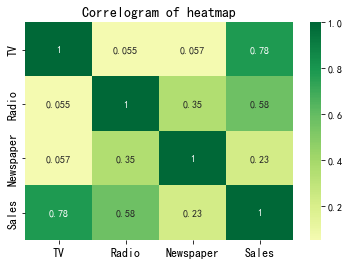

							多元线性回归系数及t检验
变量间方差膨胀因子VIF：
TV : 2.486771835198193
Radio : 3.285462100162896
Newspaper : 3.0552445106573853
----------------------------------------------------------------------------------------------------
多元线性回归系数如下：
 [ 4.45840201e-02  1.96497034e-01 -2.78146398e-03  2.99489303e+00]
----------------------------------------------------------------------------------------------------
拟合优度R2 = 0.90671   修正R2 = 0.90430
----------------------------------------------------------------------------------------------------
F = 376.62810   P = 1.034157e-78
----------------------------------------------------------------------------------------------------
[30.115162340485295, 21.923321995382704, -0.449283325970939, 9.04716316957708]
[5.852352247784431e-67, 1.1671076295210963e-49, 0.6730725662225641, 2.880924828774169e-16]


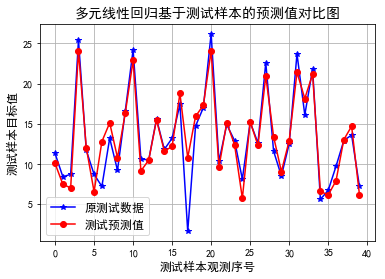

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lg
import scipy.stats as ss
from sklearn.model_selection import train_test_split
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols #加载ols模型

plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus'] = False #显示负号


class Multiple_Linear_Regression:
    """
    多元线性回归，正规方程求解，不考虑正则化
    """
    def __init__(self, url, attribute_list, target_y): #初始化
        self.data = pd.read_csv(url).dropna() #加载数据
        self.attr_label = attribute_list #自变量的样本特征名称
        self.target_label = target_y #因变量的标签名称
        self.x = np.array(self.data.loc[:, self.attr_label]) #样本
        self.X = np.hstack((self.x, np.ones((self.x.shape[0], 1)))) #构造常数1
        self.y = np.array(self.data.loc[:, self.target_label]) #目标值
        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, train_size = 0.8, random_state = 0)
        self.n, self.k = self.x_train.shape[0], self.x_train.shape[1] #训练样本量，样本特征数
        self.w = np.empty((1, self.k + 1)) #回归系数 #为啥是k + 1?
        self.H = np.empty((self.k + 1, self.k + 1)) #帽子矩阵(X'X)**-1
        self.y_hat = np.empty((1, self.n)) #预测值
        self.dfd = self.n - self.k - 1 #自由度
        self.rmse = 0.0 #均方根误差
        self.F = 0.0 #整个回归方程的F检验
        self.fp = 0.0 #F检验的P值，与0.05比较
        self.t_stat = [] #回归系数t检验统计量值
        self.tp = [] #回归系数t检验的p值，与0.05比较
        self.msr = 0.0 
        self.mse = 0.0
        self.y_hat = np.zeros((self.n, 1)) #列向量
        self.y_hat_test = np.zeros((self.x_test.shape[0], 1))
        self.TSS = 0.0 #总偏差平方和
        self.RSS = 0.0 #残差平方和
        self.ESS = 0.0 #回归平方和
        
        
        
    def calulate_corr(self):
        """
        样本属性间相关系数计算和热力图绘制
        """
        self.attr_label.append(self.target_label)
        sample = self.data.loc[:, self.attr_label]
        coefficient = sample.corr(method = 'pearson')
        #绘制相关系数矩阵热力图
        sns.heatmap(coefficient, cmap = 'RdYlGn', center = 0, annot = True) #annot 参数是在热力图里面显示数据
        plt.title('Correlogram of heatmap', fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.show()
        
    def calulate_vif(self):
        """
        多重共线性判断，计算方差膨胀因子vif
        诊断规则：VIF<5,则不存在共线性(或共线性较弱);
                5≤VIF≤10 中等程度共线性;
                VIF>10共线性严重，必须消除共线性。
        方法：去除变量，变量变换，岭回归，主成分回归
        """
        sample_x = self.data.loc[:, self.attr_label[:-1]]
        #可根据自变量的相关系数矩阵R计算各自变量的方差膨胀因子
        vif = [variance_inflation_factor(sample_x, i) for i in range(sample_x.shape[1])]
        print("\t" * 7 + "多元线性回归系数及t检验")
        print("=" * 100)
        print("变量间方差膨胀因子VIF：")
        for i in range(sample_x.shape[1]):
            print(self.attr_label[i], ":", vif[i])
            
#         coefficient = sample_x.corr(method='pearson')
#         for i, label in enumerate(self.attr_label[:-1]):
#             sub_x = coefficient.drop(label, axis=1).drop(label)
#             print(sub_x)

#             v = np.linalg.det(sub_x) / np.linalg.det(coefficient)
#             print(v)

#         vif = np.diag(np.linalg.inv(coefficient))
#         print(vif)
    
    def multiple_model(self):
        """
        多元线性回归正规方程模型系数求解
        """
        self.H = self.x_train.T.dot(self.x_train)
        if np.all(lg.eigvals(self.H) > 0): #特征值
            self.w = lg.inv(self.H).dot(self.x_train.T).dot(self.y_train) #模型系数
            print("-" * 100)
            print("多元线性回归系数如下：\n", self.w)
        else:
            print("-" * 100)
            print("帽子矩阵非正定，不可逆，不可用正规方程求解")
        self.y_hat = self.x_train.dot(self.w.T)
        self.y_hat_test = self.x_test.dot(self.w.T)
        
    
    def r_square(self):
        self.TSS = ((self.y_train - self.y_train.mean())**2).sum()
        self.RSS = ((self.y_train - self.y_hat)**2).sum()
        self.ESS = ((self.y_hat - self.y_train.mean())**2).sum()
        self.rmse = np.sqrt(self.RSS / self.n)
        self.r2 = 1 - self.RSS / self.TSS
        self.r2_adj = 1 - (1 - self.r2) * (self.n - 1) / self.dfd
        print("-" * 100)
        print("拟合优度R2 = {:.5f}   修正R2 = {:.5f}".format(self.r2, self.r2_adj))
        
    
    def f_test(self):
        self.F = (self.ESS / self.k) / (self.RSS / self.dfd)
        self.fp = ss.f.sf(self.F, self.k, self.dfd)
        print("-" * 100)
        print("F = {:.5f}   P = {:e}".format(self.F, self.fp))
        
        
    def t_test(self):
        sigma_hat = np.sqrt(self.RSS / self.dfd)
        H_inv = lg.inv(self.H)
        for i in range(len(self.w)):
            self.t_stat.append(self.w[i] / sigma_hat / np.sqrt(np.diag(H_inv)[i]))
            self.tp.append(ss.t.sf(self.t_stat[i], self.dfd))
        print("-" * 100)
        print(self.t_stat)
        print(self.tp)
        
    def plt_MLRM(self):
        plt.plot(self.y_test, 'b*-', label = "原测试数据")
        plt.plot(self.y_hat_test, 'ro-', label = "测试预测值")
        plt.xlabel("测试样本观测序号", fontdict = {"fontsize" : 12})
        plt.ylabel("测试样本目标值", fontdict = {"fontsize" : 12})
        plt.title("多元线性回归基于测试样本的预测值对比图", fontdict = {"fontsize" : 14})
        plt.grid()
        plt.legend(fontsize = 12)
        plt.show()
    

if __name__ == '__main__':
    url = 'Advertising.csv'
    attribute_list = ['TV', 'Radio', 'Newspaper']
    target_y = 'Sales'
    mlr = Multiple_Linear_Regression(url, attribute_list, target_y)
    mlr.calulate_corr()
    mlr.calulate_vif()
    mlr.multiple_model()
    mlr.r_square()
    mlr.f_test()
    mlr.t_test()
    mlr.plt_MLRM()